<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, Lasso

sns.set_style('darkgrid')

%config InlineBackend.figure_format = 'retina'

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## <font color='blue'> EDA for fixed features

In [2]:
# Load data
house = pd.read_csv('housing.csv')

In [3]:
# shape of df
print('Shape of house df: {}'.format(house.shape))

Shape of house df: (1460, 81)


In [4]:
# df info
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# value_counts() for 'MSZoning'
house['MSZoning'].value_counts() # 10 rows where 'MSZoning' == 'C (all)' that we need to remove

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
# re-assign house df after filtering out 'C (all)' from 'MSZoning'
house = house[house['MSZoning'] != 'C (all)']

print('house df shape: {}'.format(house.shape))

house df shape: (1450, 81)


In [7]:
# value_counts() for 'YrSold'
house['YrSold'].value_counts() # 1,278 rows in train set (pre-2010 data) and 172 rows in test set (2010 data)

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

In [8]:
# drop column 'Id'
house = house.drop('Id',axis=1,inplace=False)

print('house df: {}'.format(house.shape),'\n')

# assigning cols_not_fixed as list representing features that are determined to be non-fixed housing characteristics
cols_not_fixed = ['Utilities','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
                  'MasVnrArea','ExterQual','ExterCond','Heating','HeatingQC','CentralAir','Electrical','Functional',
                  'Fireplaces','FireplaceQu','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PavedDrive',
                  'WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence',
                  'MiscFeature','MiscVal','MoSold','YrSold','SaleType','SaleCondition']

print('No. of features not fixed (excluding target \'SalePrice\'): {}'.format(len(cols_not_fixed)),'\n')

# assigning cols_fixed as list representing features that are determined to be fixed housing characteristics
cols_fixed = []

for col in house.columns:
    if col not in cols_not_fixed and col != 'SalePrice':                                       
        cols_fixed.append(col) # 'SalePrice' excluded as it's target variable
        
print('No. of features fixed (excluding target \'SalePrice\'): {}'.format(len(cols_fixed)))

house df: (1450, 80) 

No. of features not fixed (excluding target 'SalePrice'): 37 

No. of features fixed (excluding target 'SalePrice'): 42


In [9]:
# creating df with fixed housing characteristics as features
house_fixed = house.drop(cols_not_fixed,axis=1,inplace=False)

print('Shape of house_fixed: {}'.format(house_fixed.shape)) # no. of cols = 42 + 1 due to 'SalesPrice'

Shape of house_fixed: (1450, 43)


In [10]:
# train test split
train_fixed = house_fixed.loc[house.index[house['YrSold'] != 2010],:]
test_fixed = house_fixed.loc[house.index[house['YrSold'] == 2010],:]

print('train_fixed shape: {}'.format(train_fixed.shape),'\n')
print('test_fixed shape: {}'.format(test_fixed.shape))

train_fixed shape: (1278, 43) 

test_fixed shape: (172, 43)


In [11]:
# separating fixed features into continuous or categorical data type for train_fixed and test_fixed df
cont_fixed_col = []
cat_fixed_col = []

for col in train_fixed.columns:
    if (train_fixed[col].dtype == 'float64') or (train_fixed[col].dtype == 'int64'):
        cont_fixed_col.append(col)
    elif train_fixed[col].dtype == 'object':
        cat_fixed_col.append(col)
        
print('total length of cont and cat column lists: {}'.format(len(cont_fixed_col) + len(cat_fixed_col)),'\n')

print('continuous variables are:')
print('--------------------------')
print(cont_fixed_col,'\n'*2)
print('categorical variables are:')
print('--------------------------')
print(cat_fixed_col)

total length of cont and cat column lists: 43 

continuous variables are:
--------------------------
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice'] 


categorical variables are:
--------------------------
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'KitchenQual', 'GarageType']


In [12]:
# check for missing values in train_fixed df and locate the column name and its no. of missing values
train_fixed_null = train_fixed.isnull().sum()

train_fixed_null_col = []
train_fixed_null_val = []

for col in train_fixed.columns[train_fixed.isnull().any()]:
    for i, x in enumerate(train_fixed_null):
        if train_fixed.columns.get_loc(col) == i:
            train_fixed_null_col.append(col)
            train_fixed_null_val.append(x)

train_fixed_null_dict = dict(zip(train_fixed_null_col, train_fixed_null_val))

print(train_fixed_null_dict,'\n')

# proportion of feature with missing values relative to number of data points (i.e. rows in df)
prop_train_fixed_null = []

for col in train_fixed_null_col:
    prop_train_fixed_null.append(round(train_fixed_null_dict[col] / train_fixed.shape[0] * 100, 2))

prop_train_fixed_null_dict = dict(zip(train_fixed_null_col, prop_train_fixed_null))

print(prop_train_fixed_null_dict) # column 'Alley' has 93.43% of missing values within train_fixed df
                                    # we will be dropping this from train_fixed

{'LotFrontage': 227, 'Alley': 1194, 'BsmtQual': 32, 'BsmtCond': 32, 'BsmtExposure': 33, 'BsmtFinType1': 32, 'BsmtFinType2': 33, 'GarageType': 68} 

{'LotFrontage': 17.76, 'Alley': 93.43, 'BsmtQual': 2.5, 'BsmtCond': 2.5, 'BsmtExposure': 2.58, 'BsmtFinType1': 2.5, 'BsmtFinType2': 2.58, 'GarageType': 5.32}


In [13]:
# check for missing values in test_fixed df and locate the column name and its no. of missing values
test_fixed_null = test_fixed.isnull().sum()

test_fixed_null_col = []
test_fixed_null_val = []

for col in test_fixed.columns[test_fixed.isnull().any()]:
    for i, x in enumerate(test_fixed_null):
        if test_fixed.columns.get_loc(col) == i:
            test_fixed_null_col.append(col)
            test_fixed_null_val.append(x)

test_fixed_null_dict = dict(zip(test_fixed_null_col, test_fixed_null_val))

print(test_fixed_null_dict,'\n')

# proportion of feature with missing values relative to number of data points (i.e. rows in df)
prop_test_fixed_null = []

for col in test_fixed_null_col:
    prop_test_fixed_null.append(round(test_fixed_null_dict[col] / test_fixed.shape[0] * 100, 2))

prop_test_fixed_null_dict = dict(zip(test_fixed_null_col, prop_test_fixed_null))

print(prop_test_fixed_null_dict) # similarly, column 'Alley' has a high percentage of missing values
                                # within the test_fixed df. hence, we will drop it from test_fixed

{'LotFrontage': 32, 'Alley': 167, 'BsmtQual': 5, 'BsmtCond': 5, 'BsmtExposure': 5, 'BsmtFinType1': 5, 'BsmtFinType2': 5, 'GarageType': 11} 

{'LotFrontage': 18.6, 'Alley': 97.09, 'BsmtQual': 2.91, 'BsmtCond': 2.91, 'BsmtExposure': 2.91, 'BsmtFinType1': 2.91, 'BsmtFinType2': 2.91, 'GarageType': 6.4}


In [14]:
# drop feature 'Alley' from both null dictionaries
train_fixed_null_dict.pop('Alley')
test_fixed_null_dict.pop('Alley')

167

In [15]:
# drop feature 'Alley' from train_fixed and test_fixed dfs
train_fixed = train_fixed.drop('Alley', axis = 1, inplace = False)
test_fixed = test_fixed.drop('Alley', axis = 1, inplace = False)

print('shape of train_fixed df: {}'.format(train_fixed.shape),'\n')
print('shape of test_fixed df: {}'.format(test_fixed.shape))

shape of train_fixed df: (1278, 42) 

shape of test_fixed df: (172, 42)


In [16]:
# drop feature 'Alley' from cat_col (the list where column names of categorical variables were stored)
cat_fixed_col.remove('Alley')

In [17]:
# imputing missing values
lotfrontage_s = train_fixed['LotFrontage']

lotfrontage_s = lotfrontage_s.dropna()

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


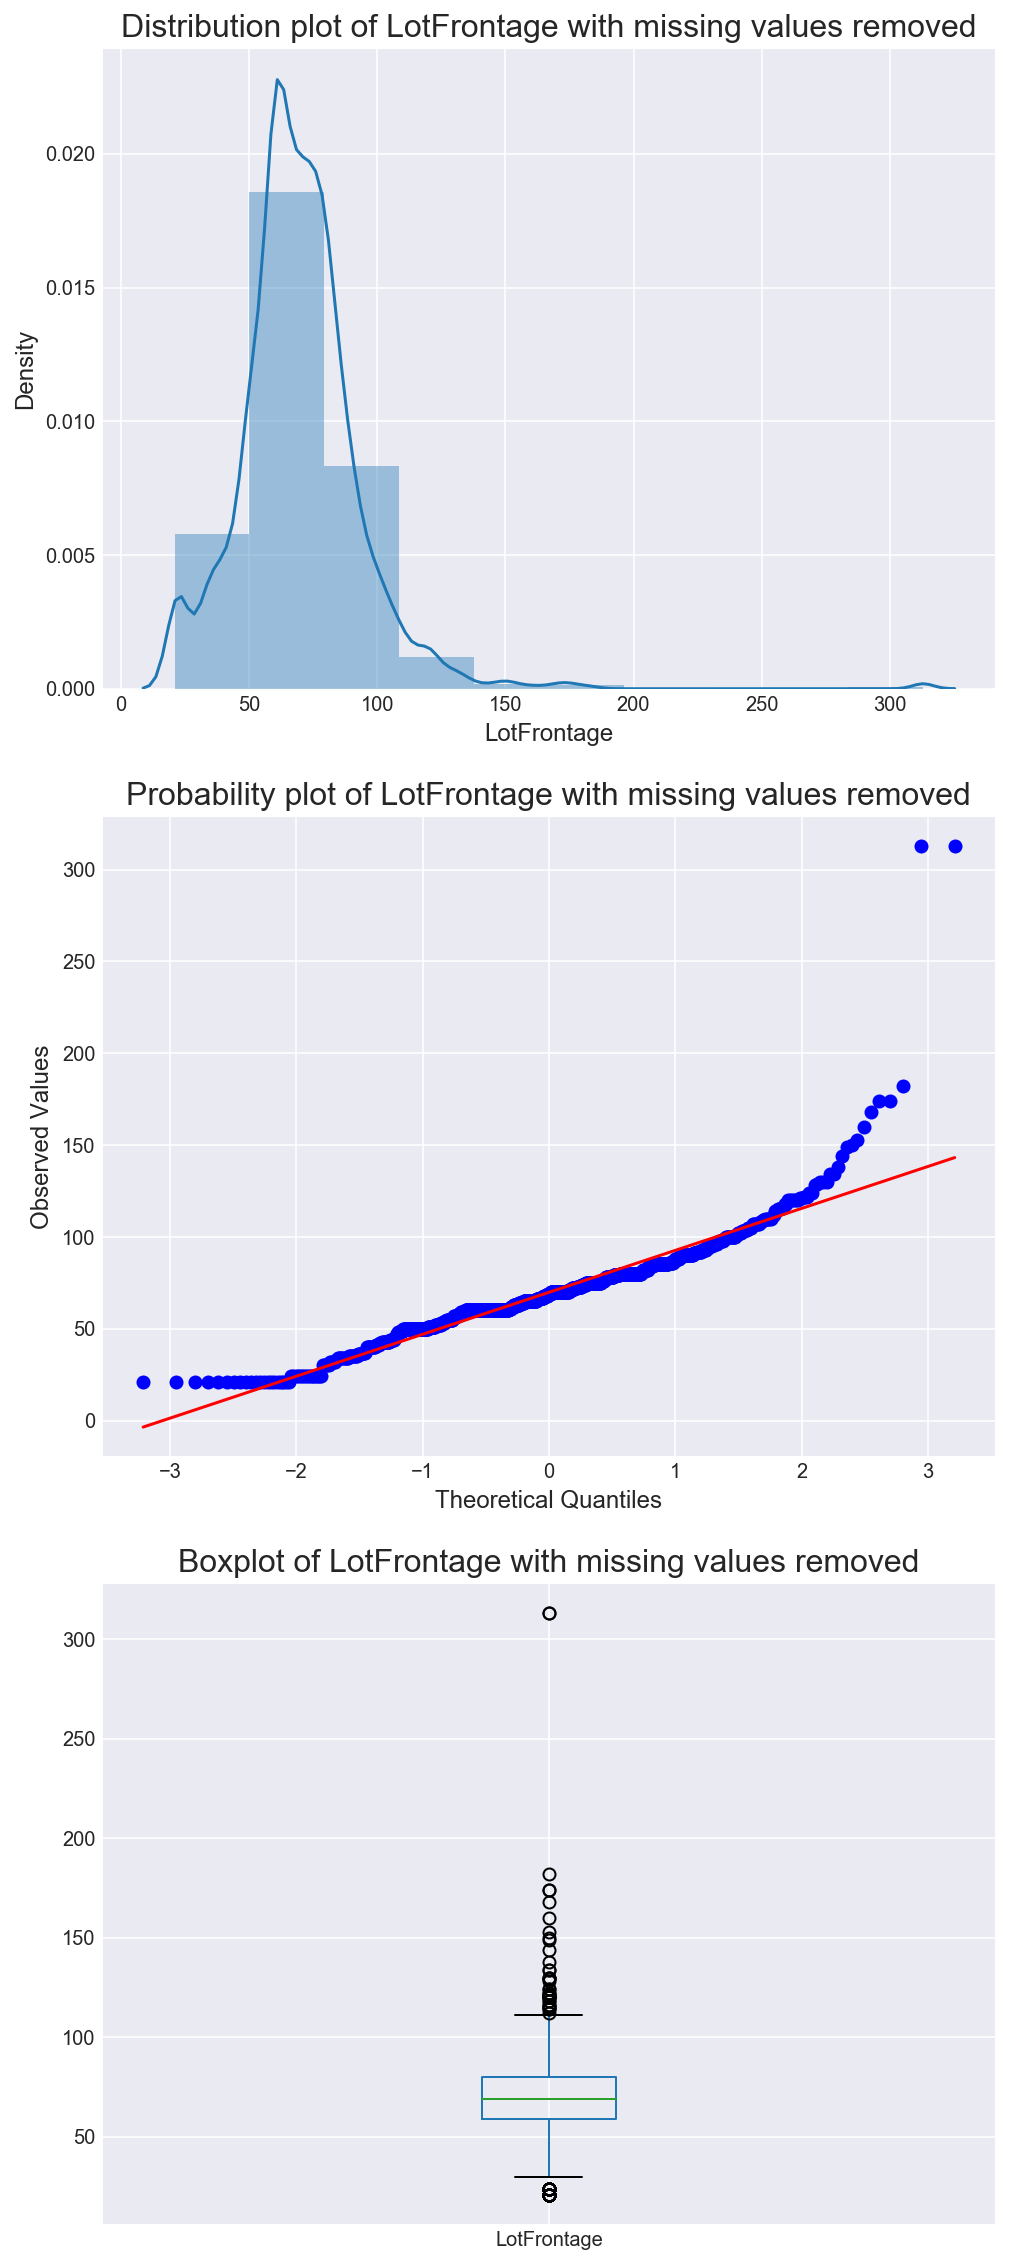

In [18]:
# checking the distribution of continuous variable: 'LotFrontage' from train_fixed df after removing
# its missing values
fig, ax = plt.subplots(3,1,figsize=(8,20))

sns.distplot(lotfrontage_s,bins = 10,ax = ax[0])
ax[0].set_title('Distribution plot of LotFrontage with missing values removed',fontsize=16)
ax[0].set_xlabel('LotFrontage',fontsize=12)
ax[0].set_ylabel('Density',fontsize=12)
ax[0].xaxis.set_tick_params(labelsize=10)
ax[0].yaxis.set_tick_params(labelsize=10)

stats.probplot(lotfrontage_s,dist=stats.norm,plot=ax[1])
ax[1].set_title('Probability plot of LotFrontage with missing values removed',fontsize=16)
ax[1].set_xlabel('Theoretical Quantiles',fontsize=12)
ax[1].set_ylabel('Observed Values',fontsize=12)
ax[1].xaxis.set_tick_params(labelsize=10)
ax[1].yaxis.set_tick_params(labelsize=10)

lotfrontage_s.plot(kind='box',ax=ax[2])
ax[2].set_title('Boxplot of LotFrontage with missing values removed',fontsize=16)
ax[2].xaxis.set_tick_params(labelsize=10)
ax[2].yaxis.set_tick_params(labelsize=10)

# there are number of outliers judging from the boxplot shown below. however, i will be using
# lasson regression later to decide if we should drop 'LotFrontage' from our regression model.
# for at least this stage, we are not dropping it

# also, we will now fill the missing values in 'LotFrontage' with its median since its distribution
# plot is showing a right skewed distribution indicating that median is a better measure for its
# central tendency

In [19]:
# imputing missing values with its median for 'LotFrontage'
lotfrontage_s_median = train_fixed['LotFrontage']
lotfrontage_s_median = lotfrontage_s_median.fillna(np.median(lotfrontage_s))

In [20]:


stats.probplot(lotfrontage_s,dist=stats.norm,plot=ax[1])
ax[1].set_title('Probability plot of LotFrontage with missing values removed',fontsize=16)


lotfrontage_s.plot(kind='box',ax=ax[2])


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


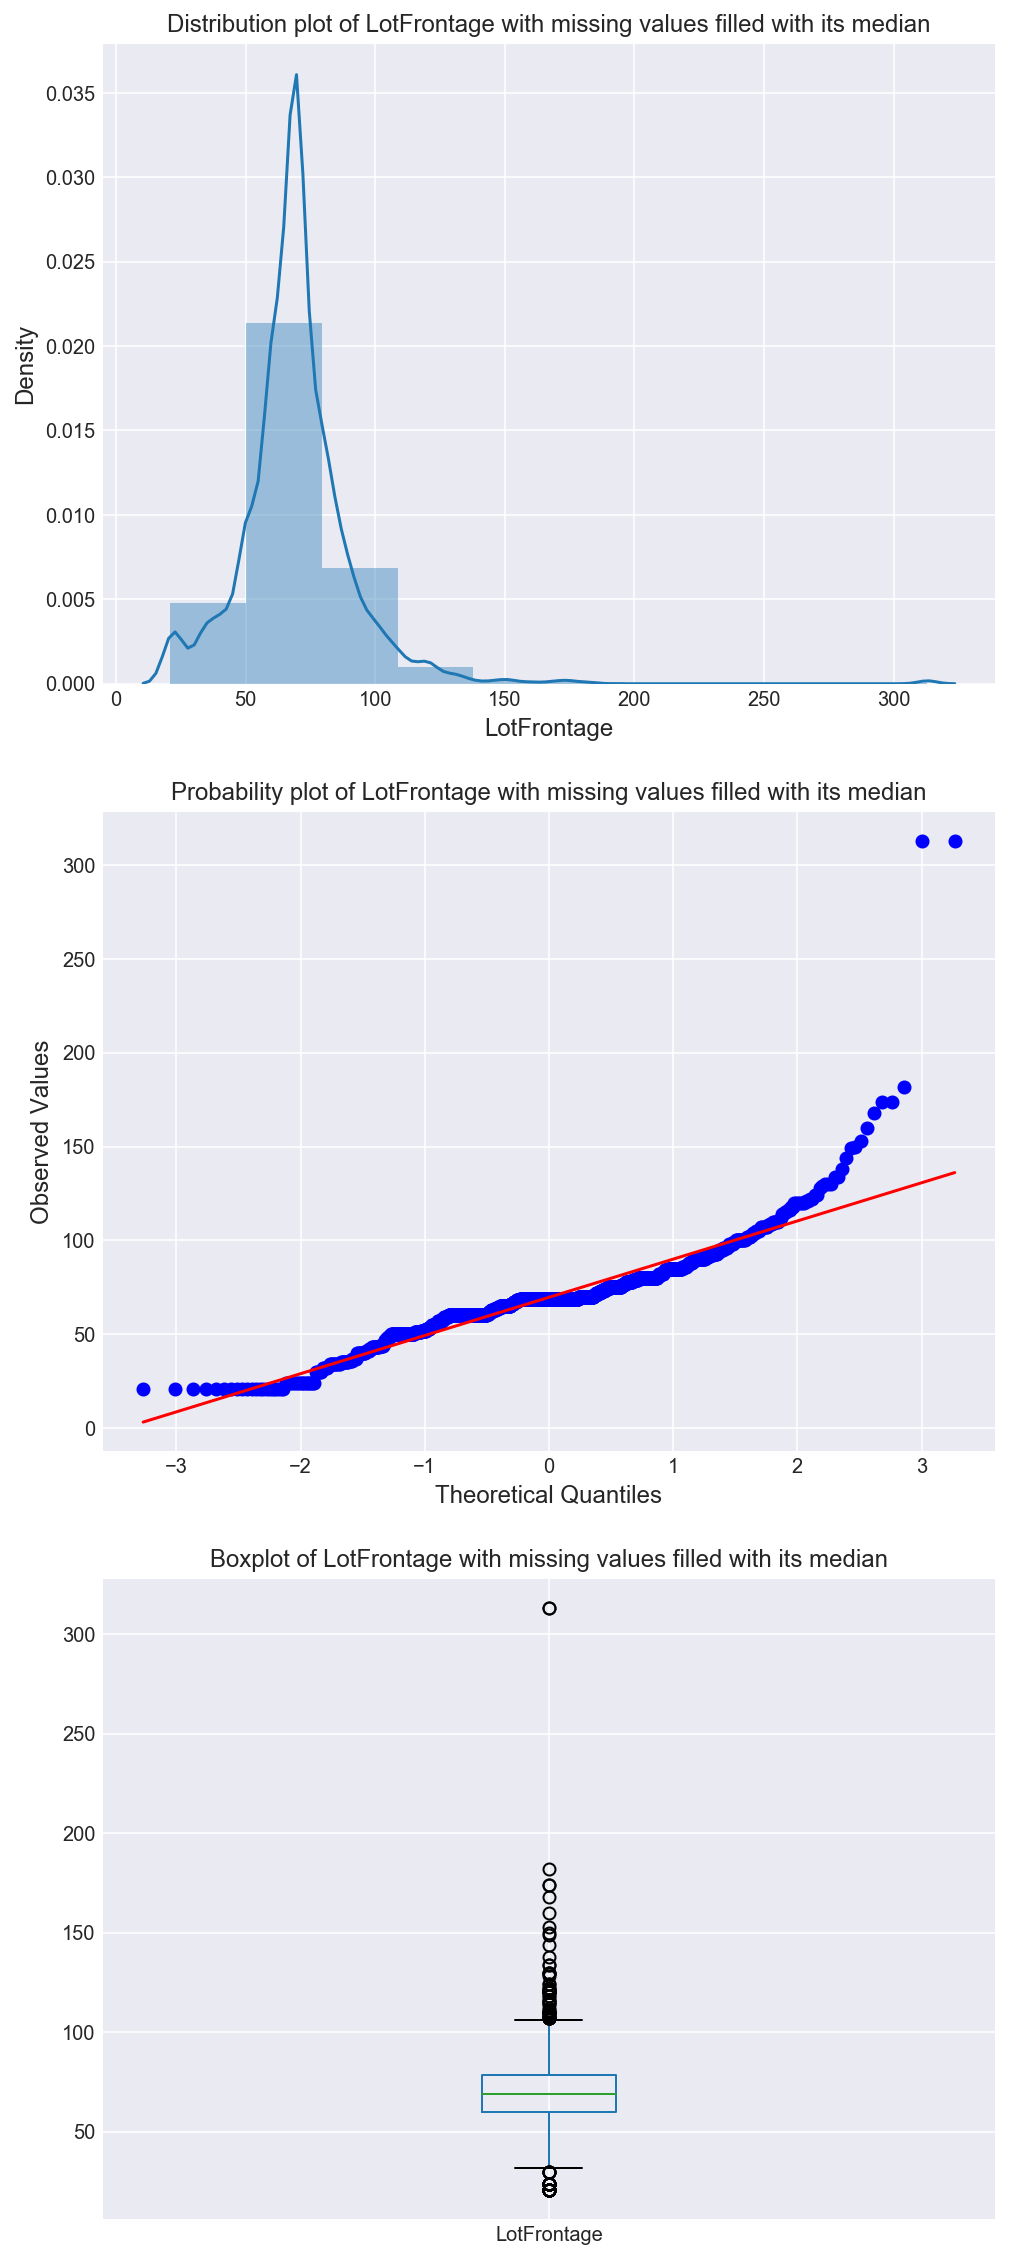

In [21]:
# checking the distribution of continuous variable: 'LotFrontage' from train_fixed df after imputing
# its missing values with its median
fig, ax = plt.subplots(3,1,figsize=(8,20))

sns.distplot(lotfrontage_s_median,bins=10,ax=ax[0])
ax[0].set_title('Distribution plot of LotFrontage with missing values filled with its median')
ax[0].set_xlabel('LotFrontage',fontsize=12)
ax[0].set_ylabel('Density',fontsize=12)
ax[0].xaxis.set_tick_params(labelsize=10)
ax[0].yaxis.set_tick_params(labelsize=10)

stats.probplot(lotfrontage_s_median,dist=stats.norm,plot=ax[1])
ax[1].set_title('Probability plot of LotFrontage with missing values filled with its median')
ax[1].set_xlabel('Theoretical Quantiles',fontsize=12)
ax[1].set_ylabel('Observed Values',fontsize=12)
ax[1].xaxis.set_tick_params(labelsize=10)
ax[1].yaxis.set_tick_params(labelsize=10)

lotfrontage_s_median.plot(kind='box',ax=ax[2])
ax[2].set_title('Boxplot of LotFrontage with missing values filled with its median')
ax[2].xaxis.set_tick_params(labelsize=10)
ax[2].yaxis.set_tick_params(labelsize=10)

In [22]:
train_fixed.isnull().sum().values

array([  0,   0, 227,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  32,  32,  33,  32,   0,  33,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  68,
         0,   0,   0], dtype=int64)

In [23]:
# imputing missing values 

# similar imputation methods will be applied to both train_fixed and test_fixed dfs

# for continuous variable 'LotFrontage', as aforementioned, the median will be used to impute missing
# values

# for categorical variables: since the proportion of missing values of categorical features are less 
# than 5 - 6% for their respective data column and by way of .value_counts() applied on these features,
# we notice that in general, there exists classes that appeared quite frequently in each of these 
# features. hence, we shall not remove these data points and instead, replace them with their 
# respective mode
train_fixed['LotFrontage'] = train_fixed['LotFrontage'].fillna(np.median(lotfrontage_s))
test_fixed['LotFrontage'] = test_fixed['LotFrontage'].fillna(np.median(lotfrontage_s))

for col in train_fixed_null_col[2::]:
    key_0 = train_fixed[col].value_counts().keys().tolist()[0]
    
    train_fixed[col] = train_fixed[col].fillna(key_0)
    test_fixed[col] = test_fixed[col].fillna(key_0)

print('shape of train_fixed df: {}'.format(train_fixed.shape),'\n')
print('shape of test_fixed df: {}'.format(test_fixed.shape),'\n')
print('------------------------------------','\n')
print('check if there are any missing value(s) in train_fixed df:')
print(train_fixed.isnull().sum().values,'\n')
print('check if there are any missing value(s) in test_fixed df:')
print(test_fixed.isnull().sum().values)

shape of train_fixed df: (1278, 42) 

shape of test_fixed df: (172, 42) 

------------------------------------ 

check if there are any missing value(s) in train_fixed df:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0] 

check if there are any missing value(s) in test_fixed df:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


In [24]:
# concatenate train_fixed and test_fixed df first before assigning classes to our 
# categorical variables
house_fixed = pd.concat([train_fixed, test_fixed], axis = 0)

print('shape of house_fixed df: {}'.format(house_fixed.shape),'\n')

house_fixed_dummy = pd.get_dummies(house_fixed,prefix=cat_fixed_col,columns=cat_fixed_col,
                                  drop_first=True)

print('shape of house_fixed_dummy: {}'.format(house_fixed_dummy.shape),'\n')

# re-assigning house_fixed_dummy df to train and test datasets
train_fixed_dummy = house_fixed_dummy.iloc[:1278, :].reset_index(drop = True)
test_fixed_dummy = house_fixed_dummy.iloc[1278:, :].reset_index(drop = True)

print('shape of train_fixed_dummy: {}'.format(train_fixed_dummy.shape),'\n')
print('shape of test_fixed_dummy: {}'.format(test_fixed_dummy.shape))

shape of house_fixed df: (1450, 42) 

shape of house_fixed_dummy: (1450, 121) 

shape of train_fixed_dummy: (1278, 121) 

shape of test_fixed_dummy: (172, 121)


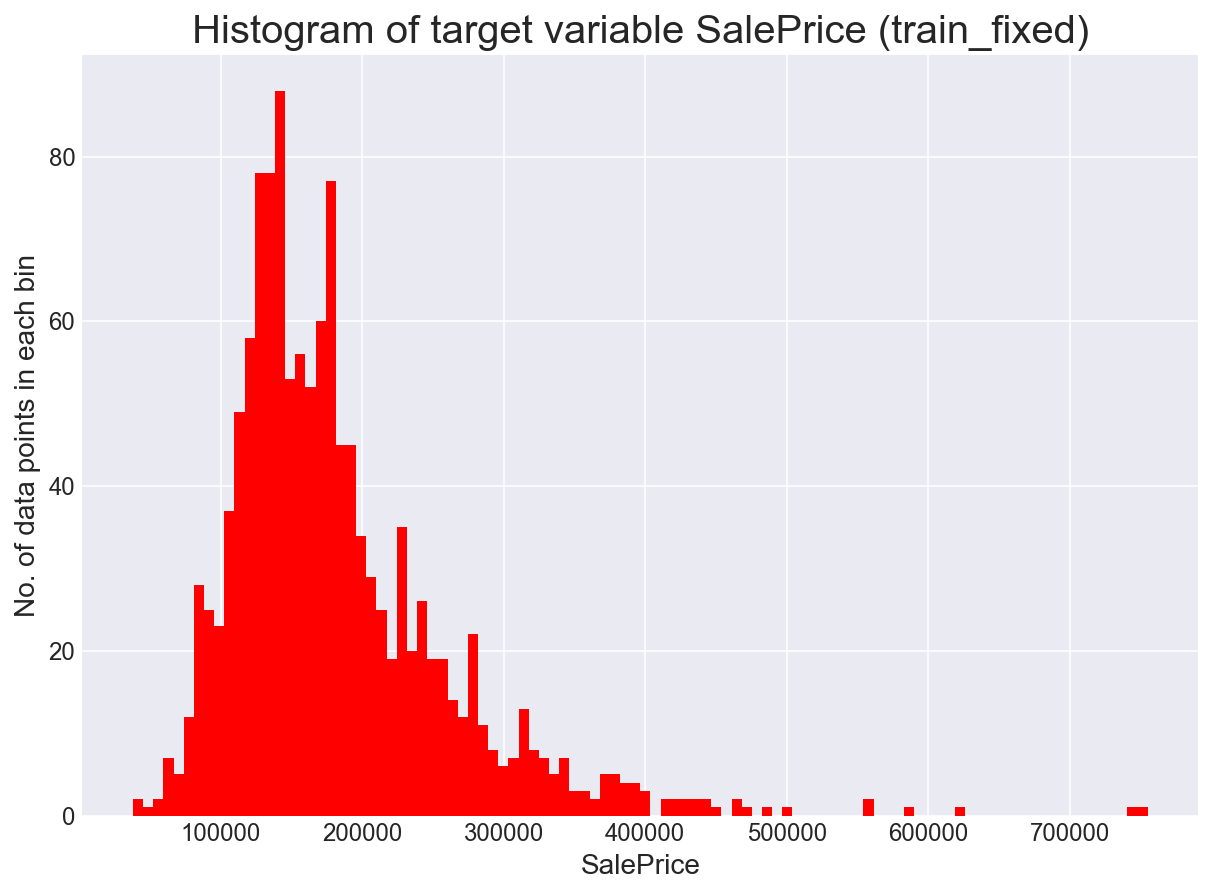

In [25]:
# plot histogram for target variable of train_fixed df
fig, ax = plt.subplots(figsize=(10,7))

ax.hist(train_fixed['SalePrice'],bins=100,color='red')

ax.set_title('Histogram of target variable SalePrice (train_fixed)',fontsize=20)
ax.set_xlabel('SalePrice',fontsize=14)
ax.set_ylabel('No. of data points in each bin',fontsize=14)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.show()

# histogram shows a right-skewed distribution

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


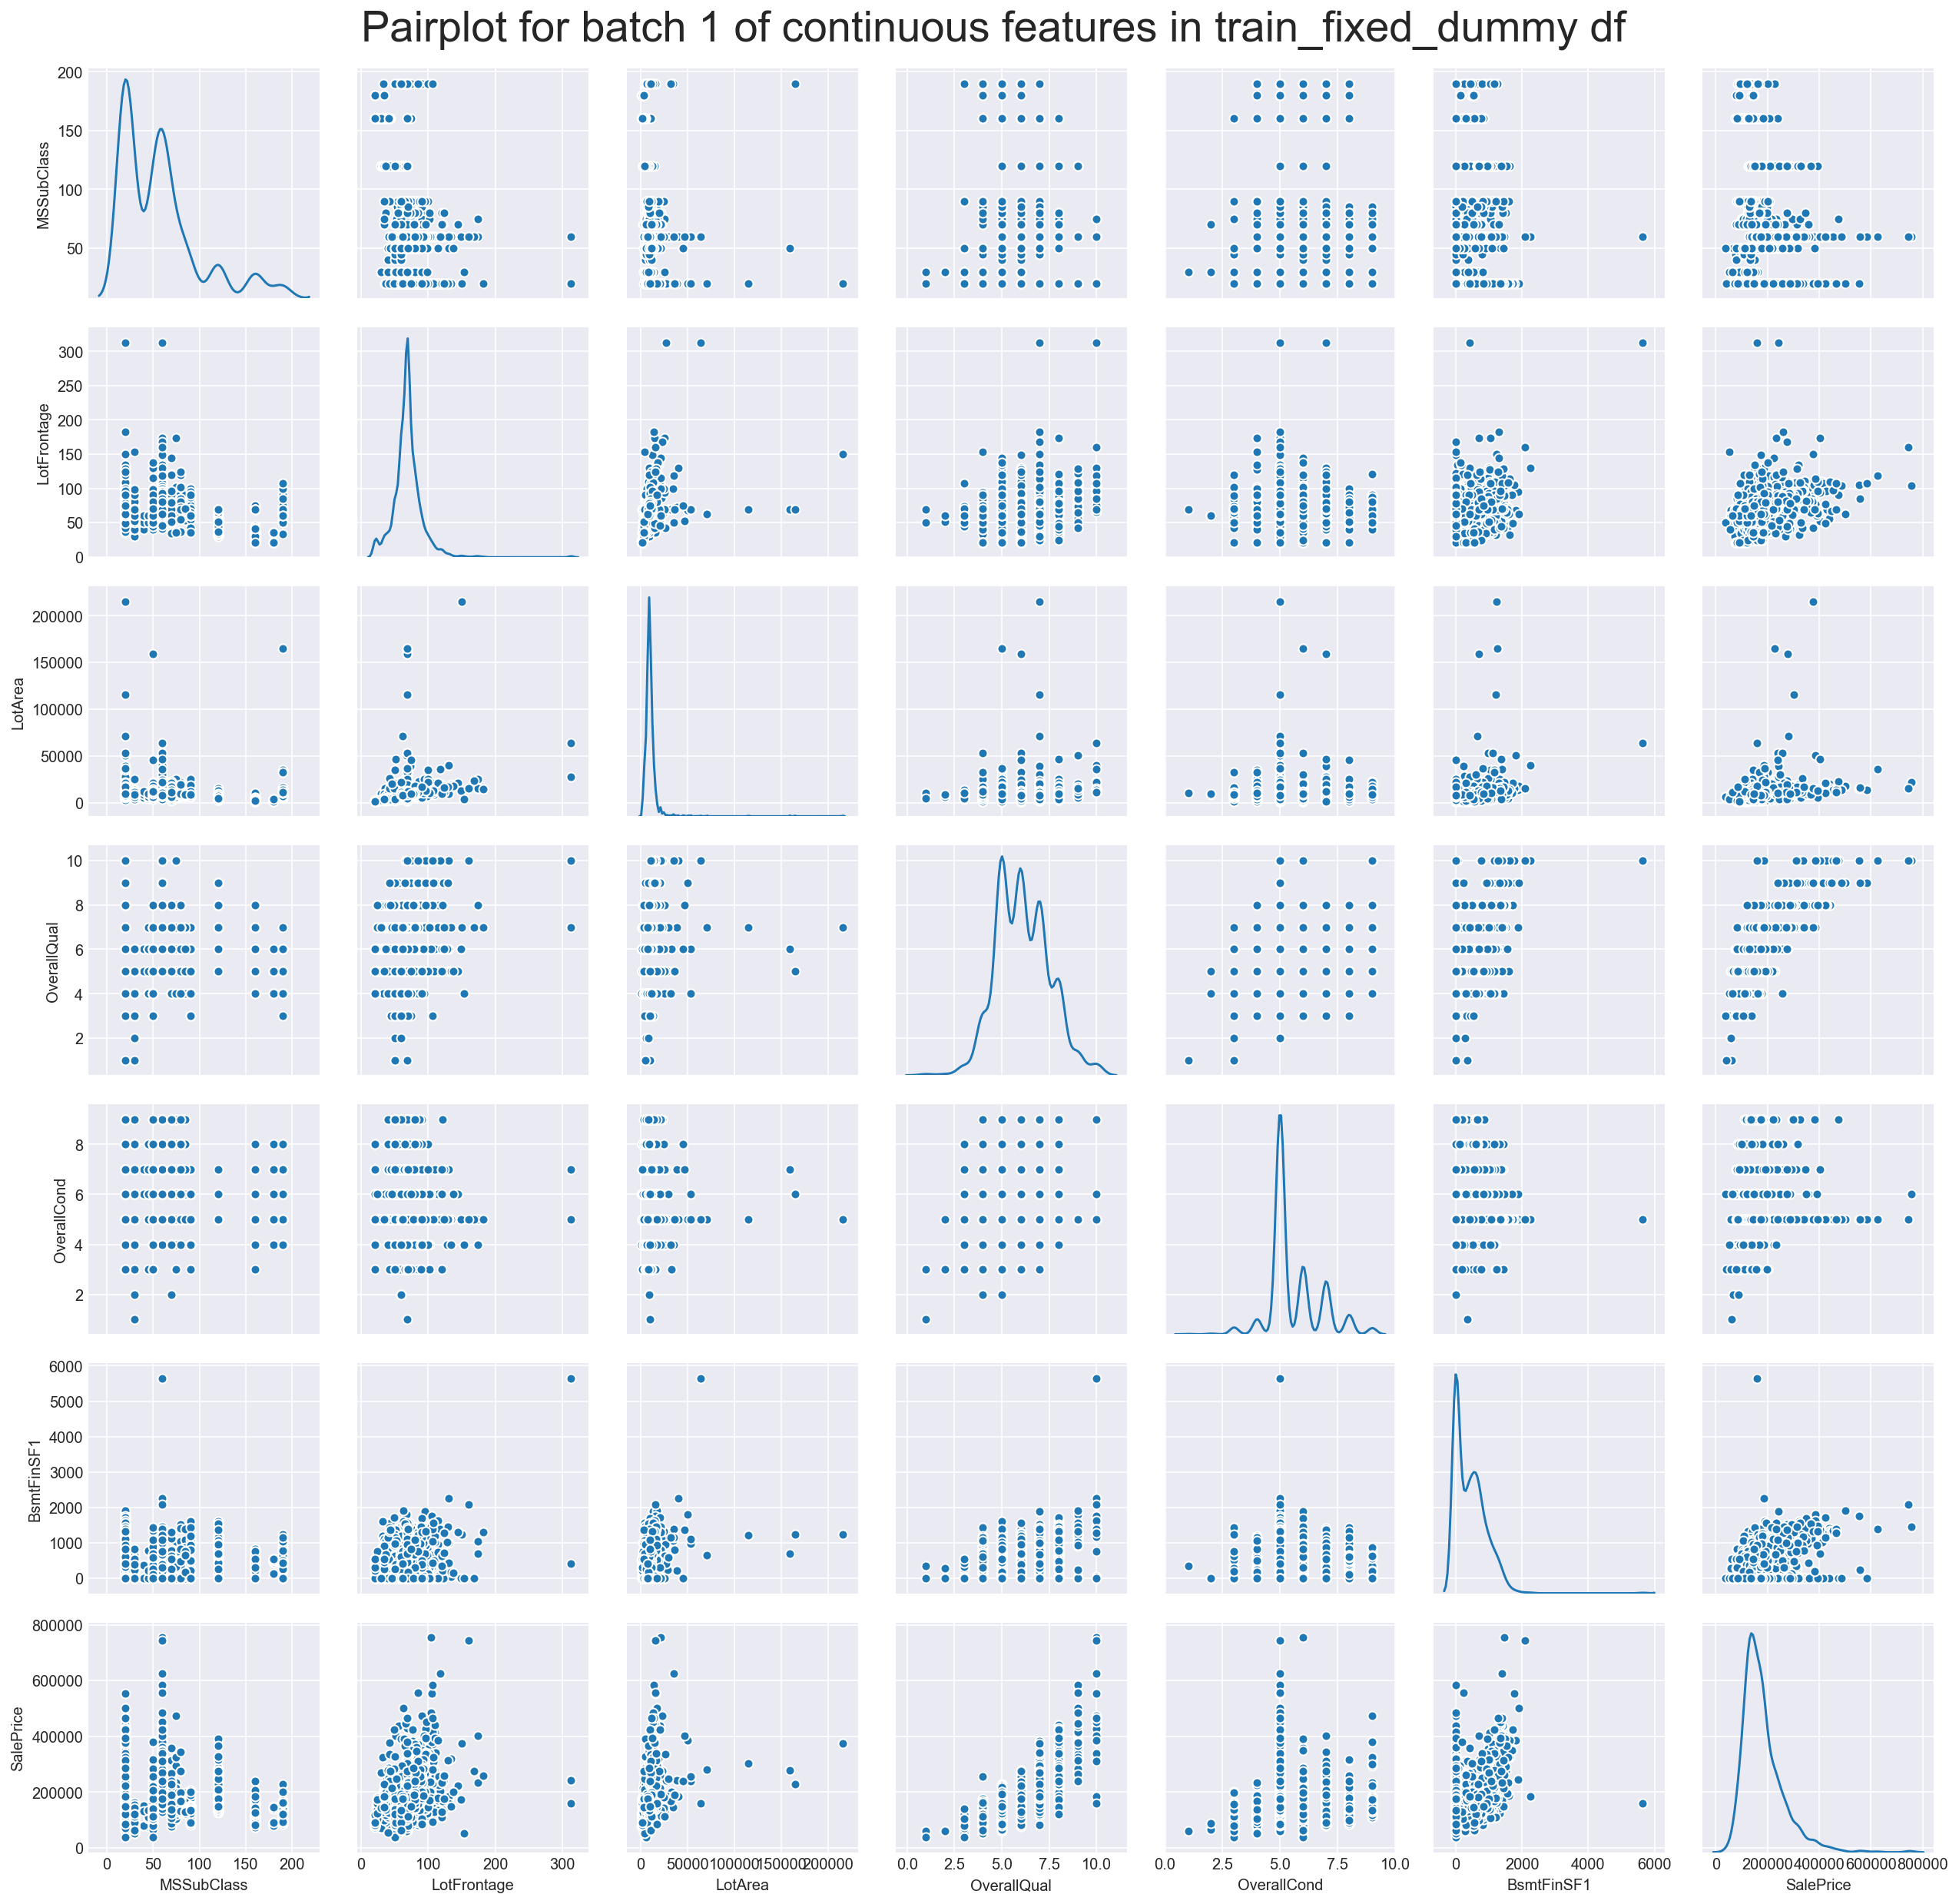

In [26]:
# plot batch 1 pairplot for continuous features and target 'SalePrice' for train_fixed
# batch 1 consists of ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond', 'BsmtFinSF1', SalePrice']
batch_1 = cont_fixed_col[0:6]
batch_1.append('SalePrice')

sns.pairplot(train_fixed_dummy[batch_1],kind='scatter',diag_kind='kde')
plt.suptitle('Pairplot for batch 1 of continuous features in train_fixed_dummy df',fontsize=28)
plt.subplots_adjust(top=0.95)

plt.show()

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


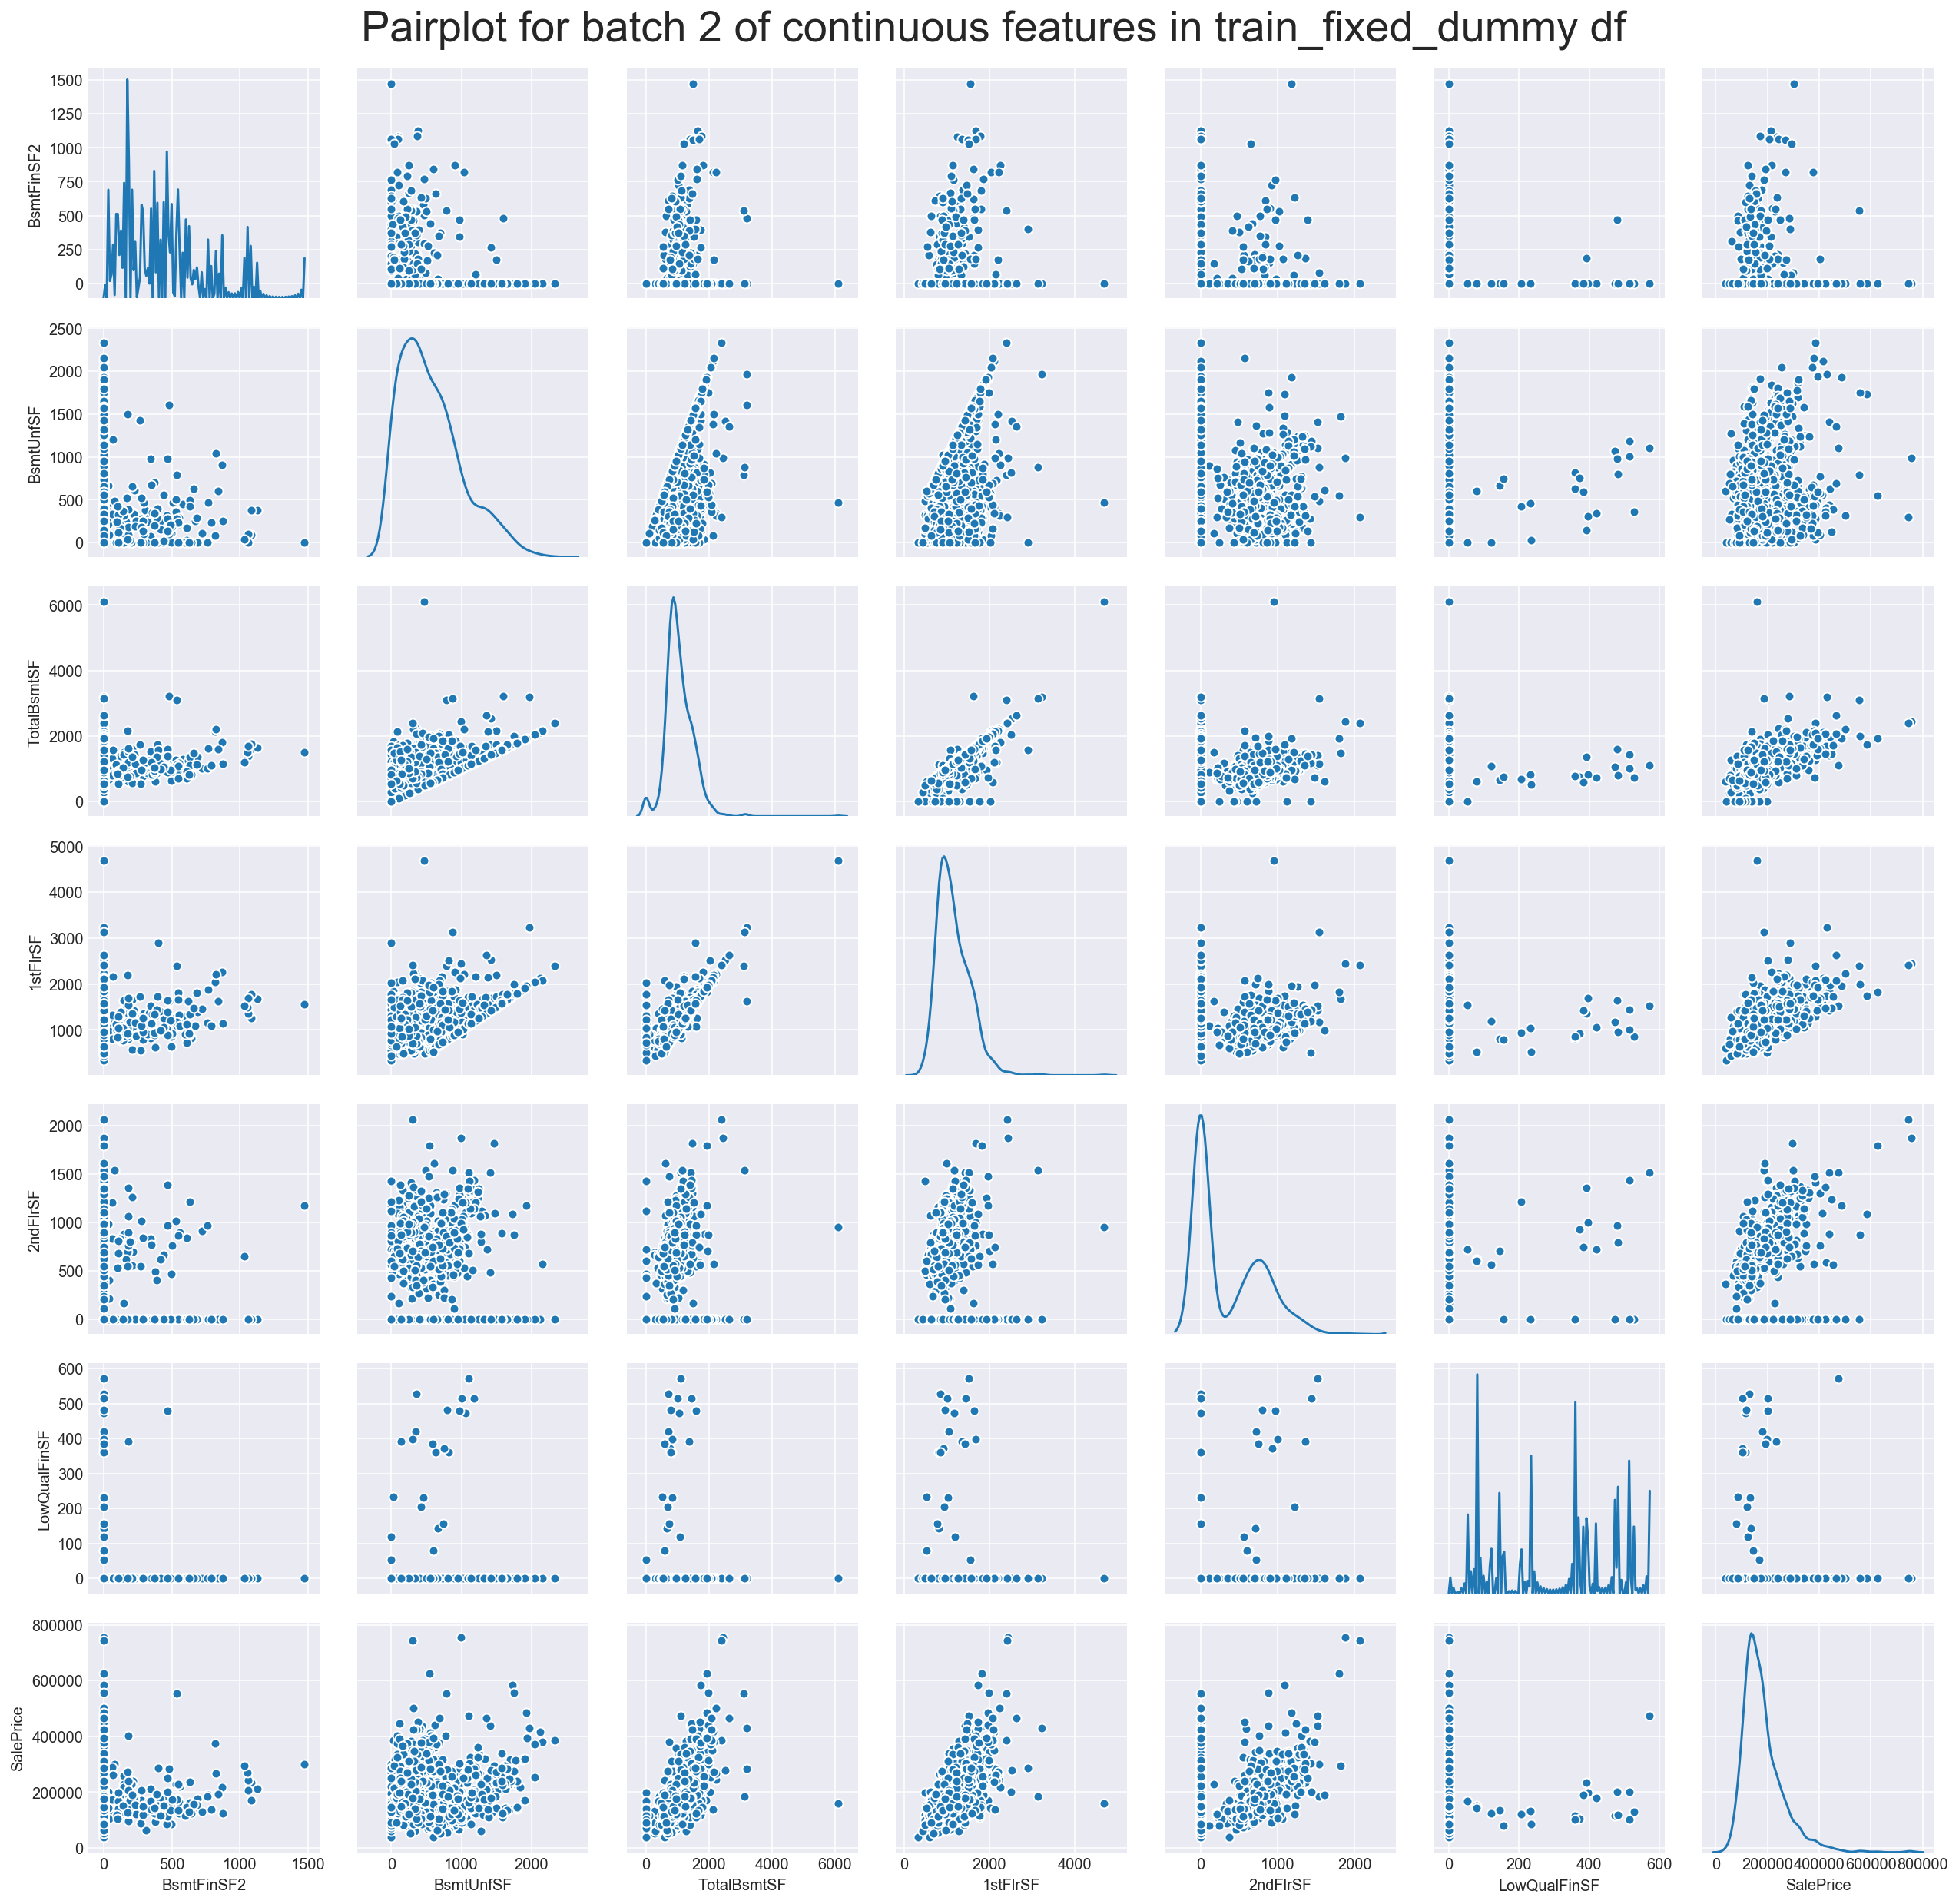

In [27]:
# plot batch 2 pairplot for continuous features and target 'SalePrice' for train_fixed
# batch 2 consists of ['BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','SalePrice']
batch_2 = cont_fixed_col[6:12]
batch_2.append('SalePrice')

sns.pairplot(train_fixed_dummy[batch_2],kind='scatter',diag_kind='kde')
plt.suptitle('Pairplot for batch 2 of continuous features in train_fixed_dummy df',fontsize=28)
plt.subplots_adjust(top=0.95)

plt.show()

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


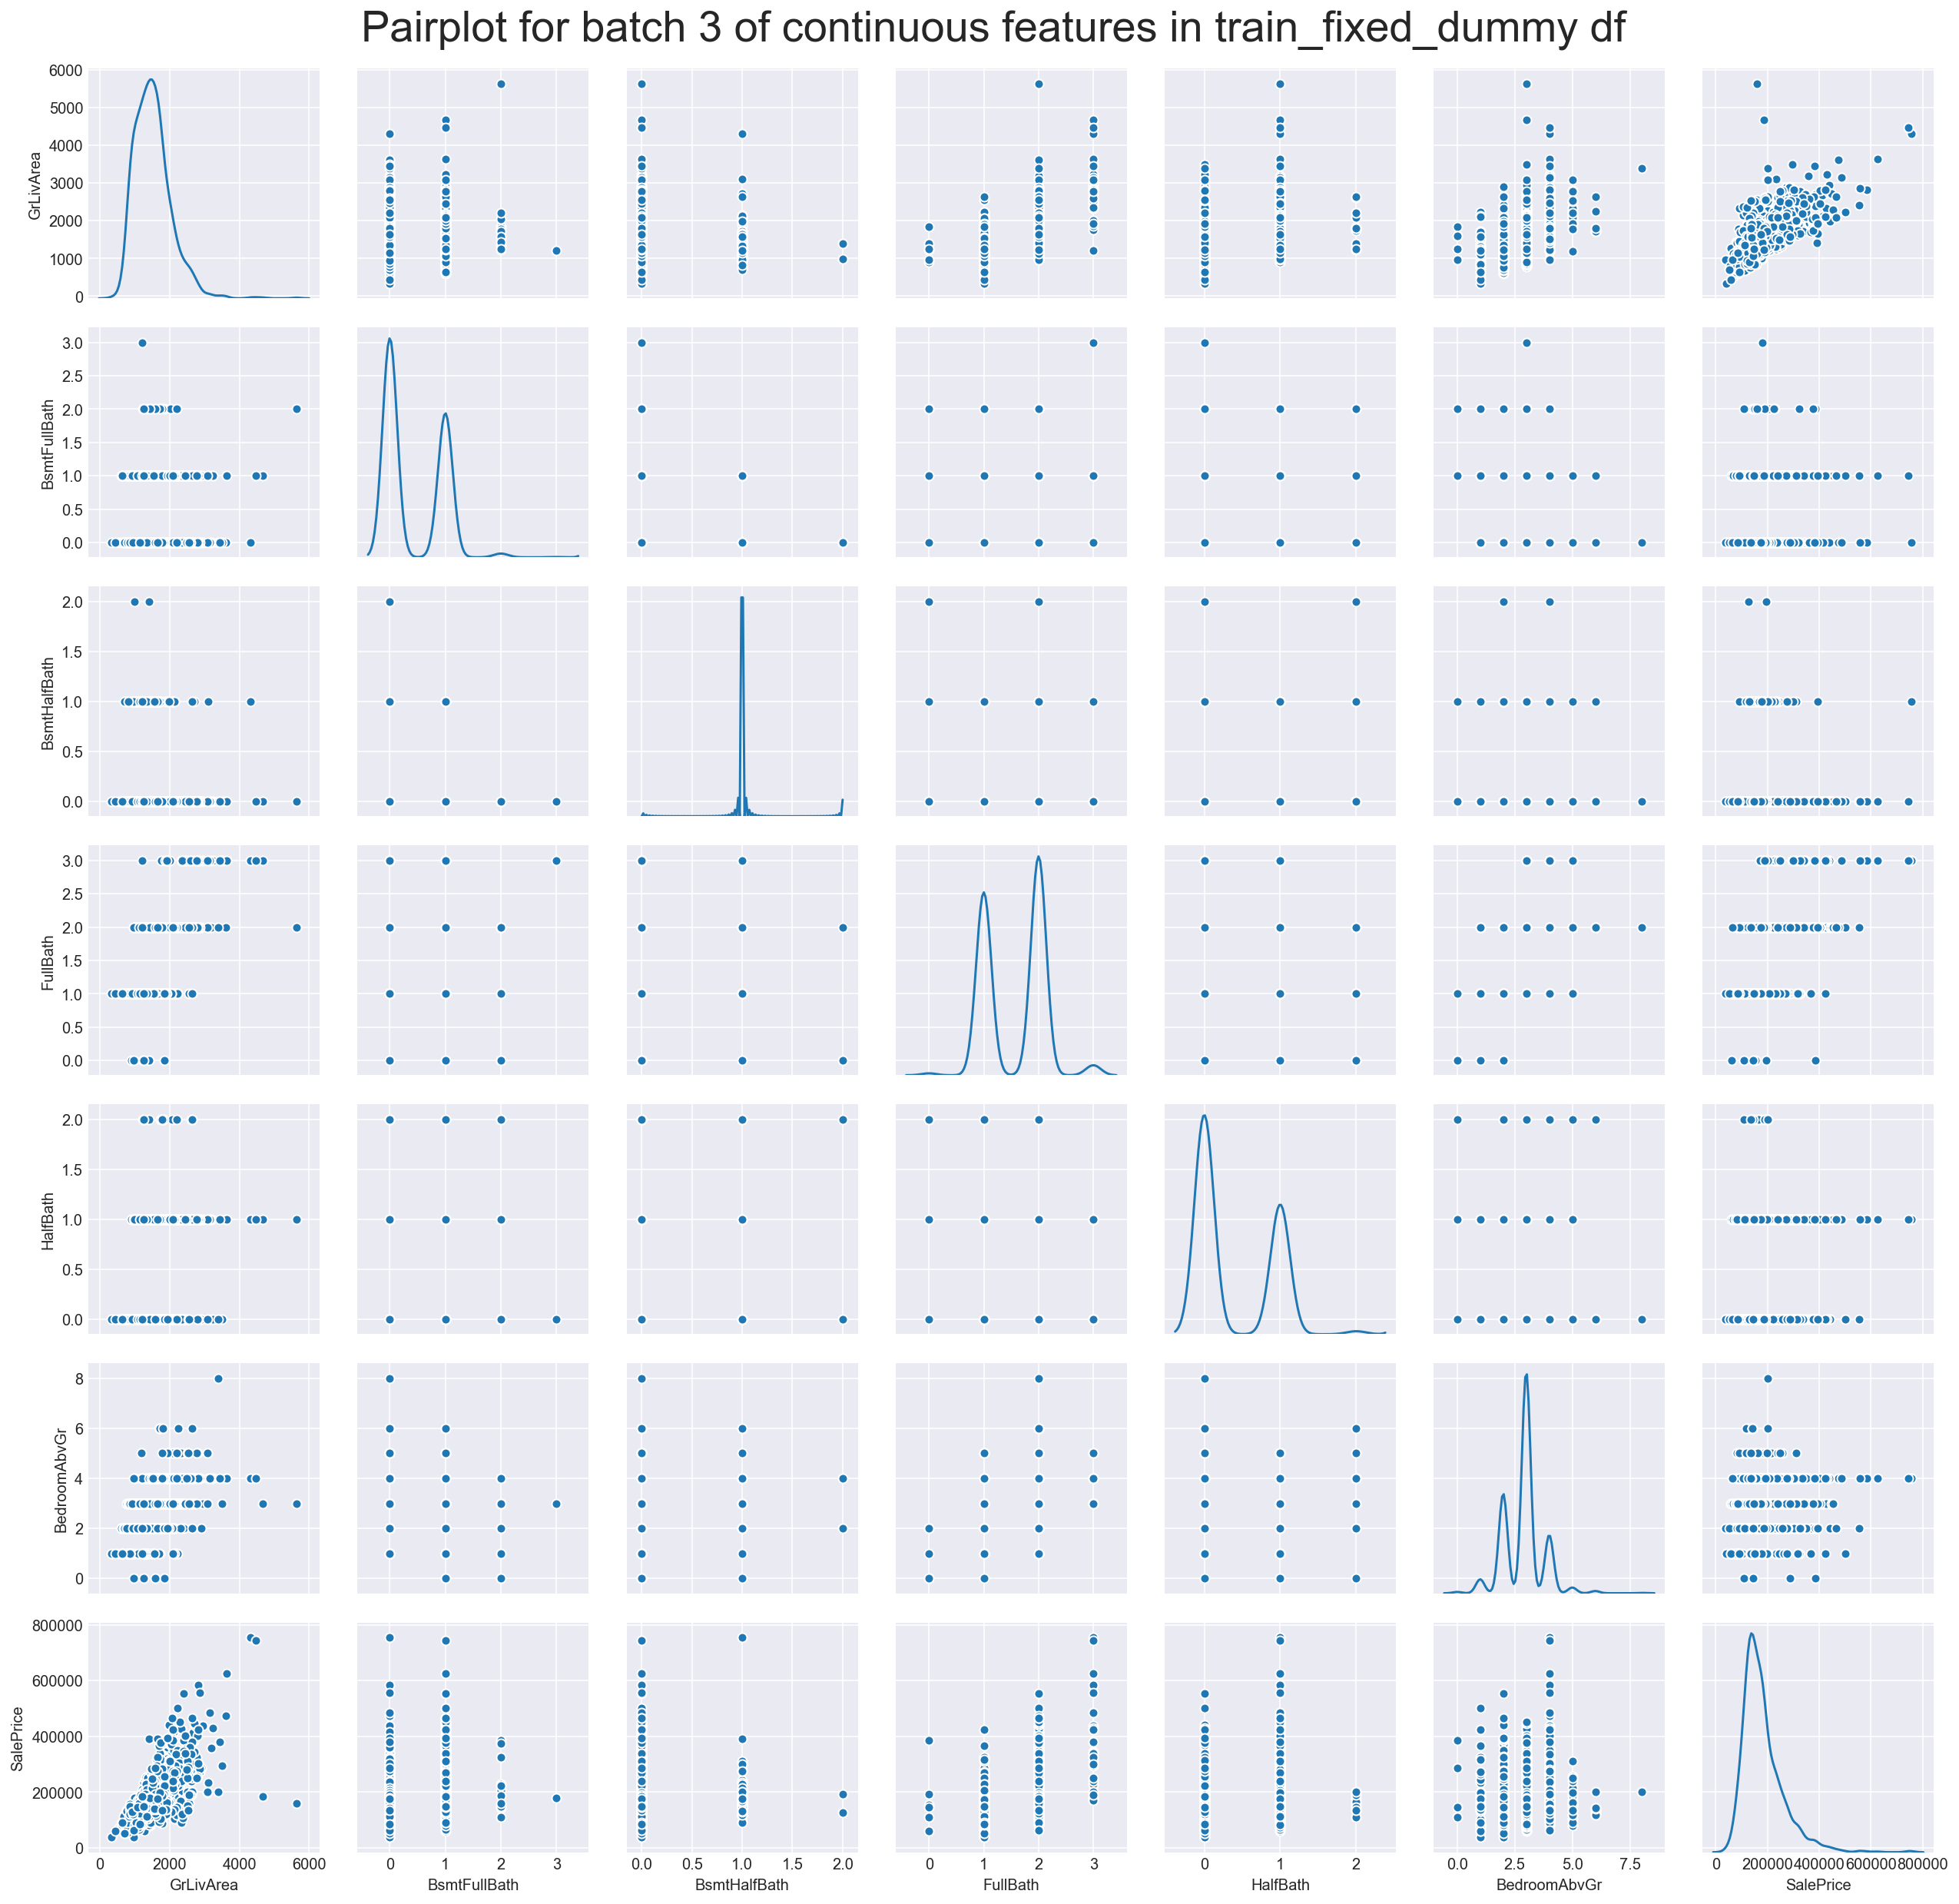

In [28]:
# plot batch 3 pairplot for continuous features and target 'SalePrice' for train_fixed
# batch 3 consists of ['GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','SalePrice']
batch_3 = cont_fixed_col[12:18]
batch_3.append('SalePrice')

sns.pairplot(train_fixed_dummy[batch_3],kind='scatter',diag_kind='kde')
plt.suptitle('Pairplot for batch 3 of continuous features in train_fixed_dummy df',fontsize=28)
plt.subplots_adjust(top=0.95)

plt.show()

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


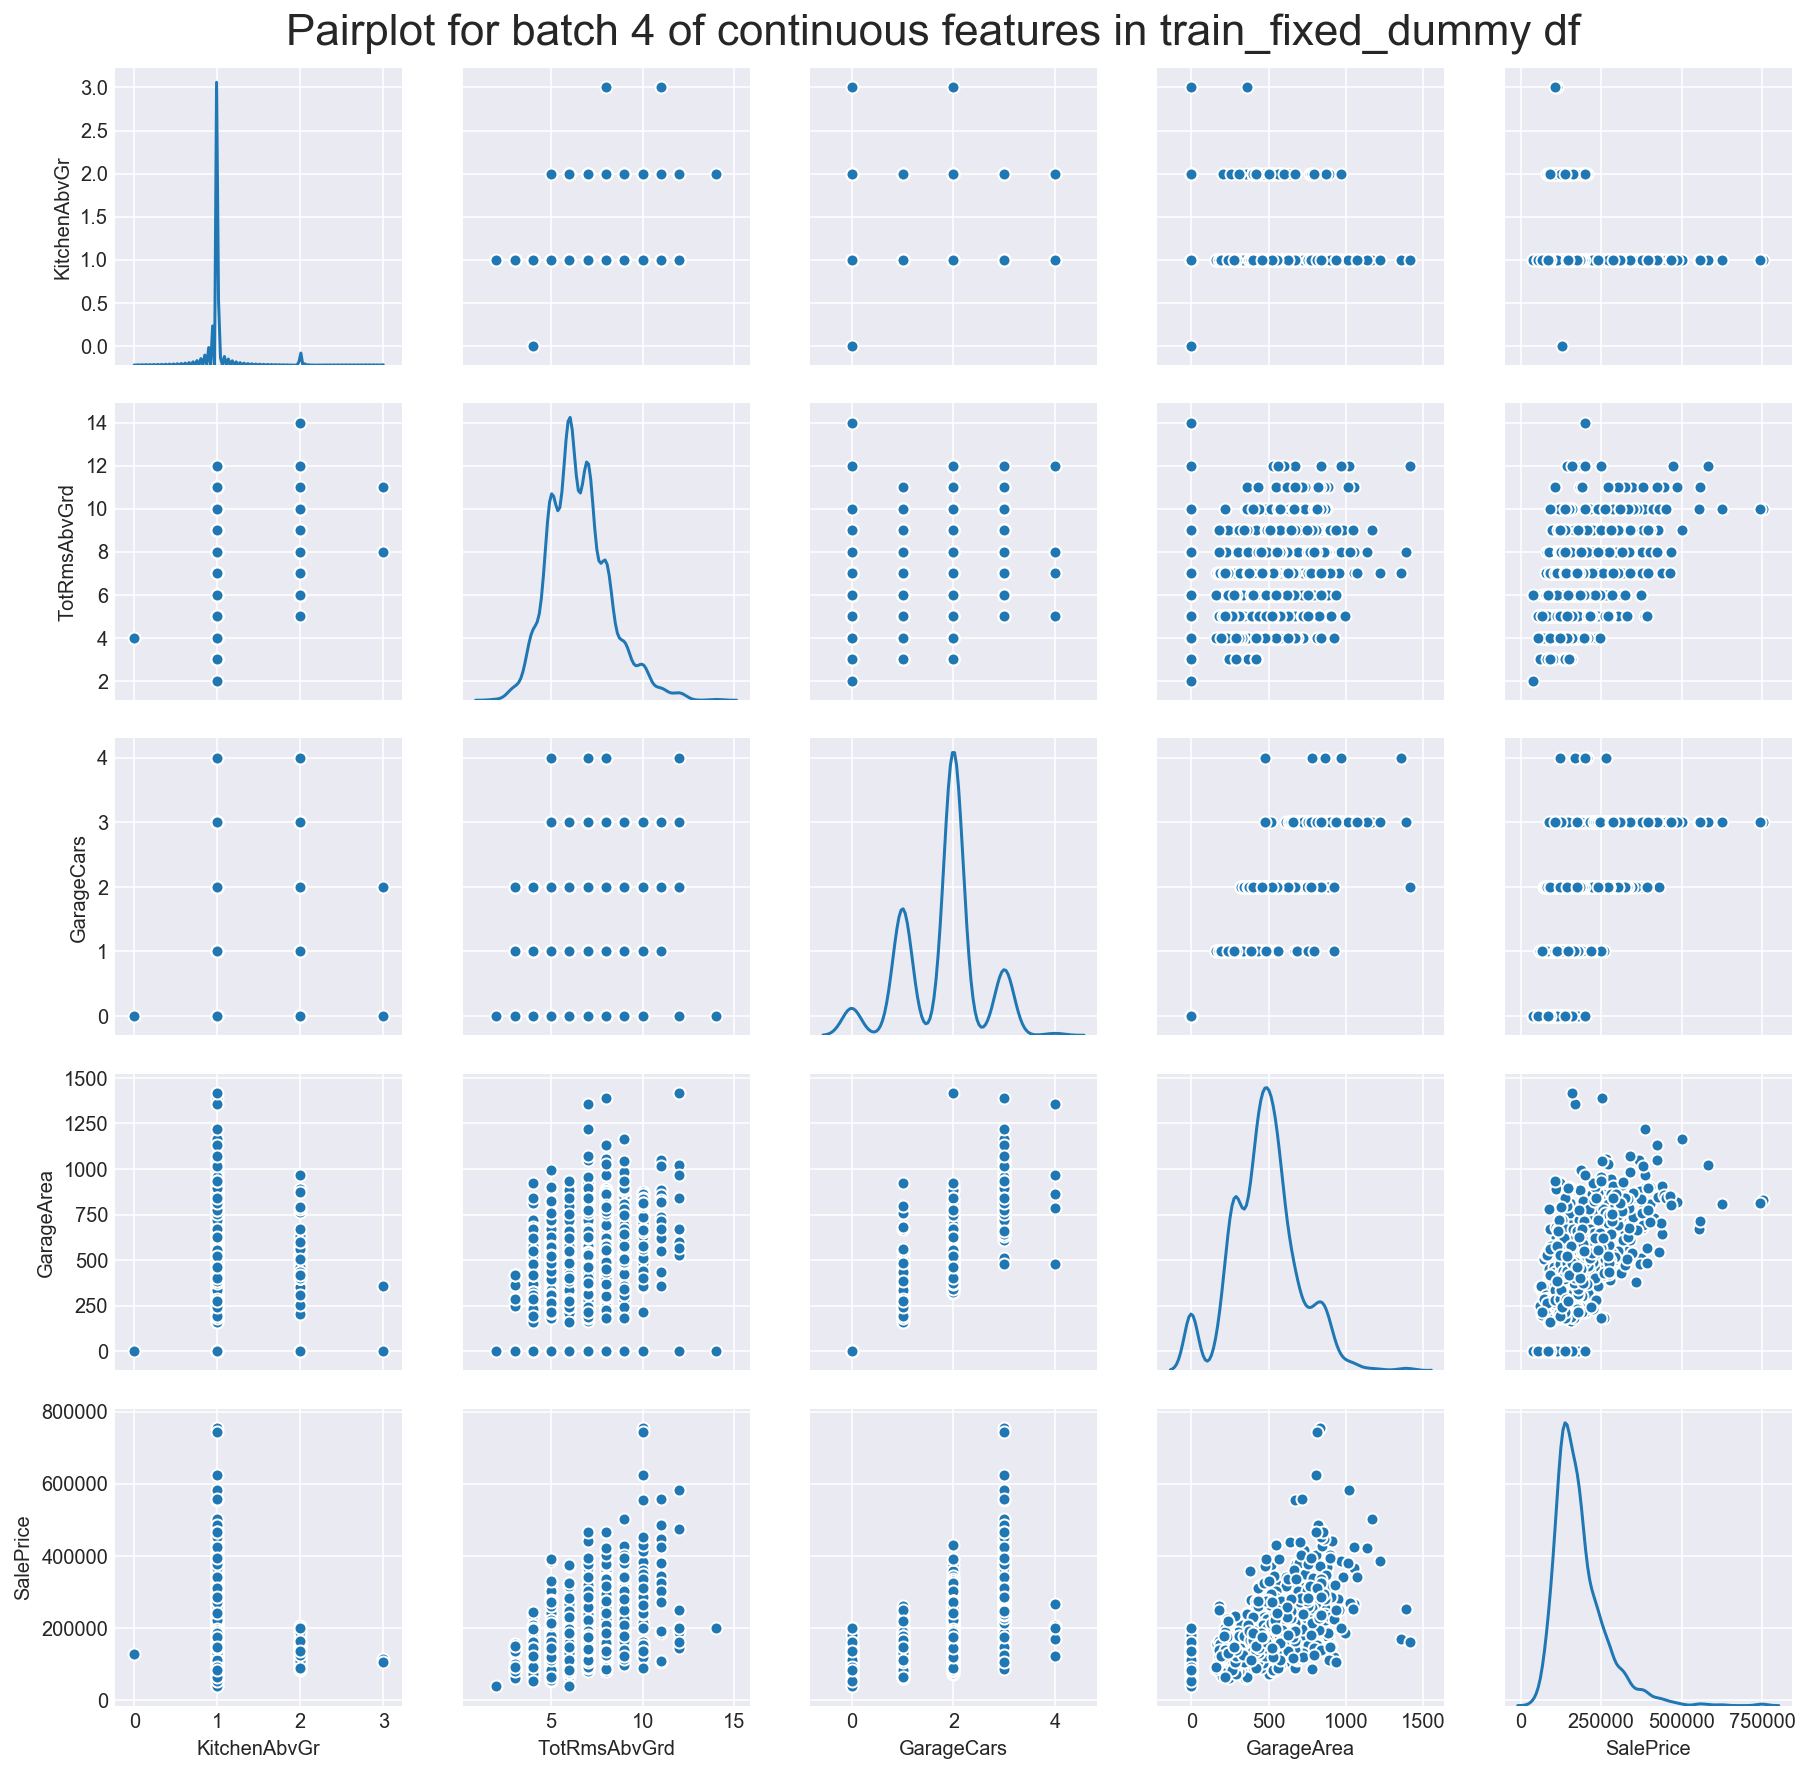

In [29]:
# plot batch 4 pairplot for continuous features and target 'SalePrice' for train_fixed
# batch 4 consists of ['KitchenAbvGr', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'SalePrice']
batch_4 = cont_fixed_col[18:22]
batch_4.append('SalePrice')

sns.pairplot(train_fixed_dummy[batch_4],kind='scatter',diag_kind='kde')
plt.suptitle('Pairplot for batch 4 of continuous features in train_fixed_dummy df',fontsize=22)
plt.subplots_adjust(top=0.95)

plt.show()

# <font color='blue'> Predictive Modelling

In [30]:
# scaling the X features for train_fixed_dummy df
# subsequently, using the mean and std from train_fixed_dummy, we shall scale the features on
# test_fixed_dummy df
scaler = StandardScaler()
train_sc = scaler.fit_transform(train_fixed_dummy)

train_sc = pd.DataFrame(train_sc)
train_sc.columns = train_fixed_dummy.columns

# scaling the X features for test_fixed_dummy
test_sc = scaler.transform(test_fixed_dummy)

test_sc = pd.DataFrame(test_sc)
test_sc.columns = test_fixed_dummy.columns

print('shape of train_sc: {}'.format(train_sc.shape),'\n')
print('shape of test_sc: {}'.format(test_sc.shape))

shape of train_sc: (1278, 121) 

shape of test_sc: (172, 121)


C:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [31]:
# splitting train_sc and test_sc to X and y variables before model fitting
X_train_sc = train_sc.drop('SalePrice',axis=1,inplace=False)
y_train_sc = train_sc.SalePrice

X_test_sc = test_sc.drop('SalePrice',axis=1,inplace=False)
y_test_sc = test_sc['SalePrice']

print('shape of X_train_sc: {}'.format(X_train_sc.shape))
print('shape of y_train_sc: {}'.format(y_train_sc.shape),'\n')
print('shape of X_test_sc: {}'.format(X_test_sc.shape))
print('shape of y_test_sc: {}'.format(y_test_sc.shape))

shape of X_train_sc: (1278, 120)
shape of y_train_sc: (1278,) 

shape of X_test_sc: (172, 120)
shape of y_test_sc: (172,)


In [32]:
# fitting multivariate linear regression to X_train_sc and y_trian_sc using statsmodels
X_train_sc_const = sm.add_constant(X_train_sc)

model_train = sm.OLS(y_train_sc,X_train_sc_const).fit()

y_pred = model_train.predict(X_train_sc_const)

model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     77.00
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:29:14   Log-Likelihood:                -420.91
No. Observations:                1278   AIC:                             1080.
Df Residuals:                    1159   BIC:                             1693.
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.433e-16      0.010   2.46e-14      1.000      -0.019       0.019
MSSubClass              -0.0606      0.051     -1.185      0.236      -0.161       0.040
LotFrontage             -0.0457      0.015     -3.145      0.002      -0.074      -0.017
LotArea                  0.0816      0.016      5.163      0.000       0.051       0.113
OverallQual              0.1767      0.021      8.501      0.000       0.136       0.217
OverallCond              0.0803      0.013      6.358      0.000       0.055       0.105
BsmtFinSF1               0.0044      0.015      0.301      0.764      -0.024       0.033
BsmtFinSF2               0.0230      0.019      1.210      0.226      -0.014       0.060
BsmtUnfSF                0.0061      0.012      0.491      0.624      -0.018       0.031
TotalBsmtSF              0.0188      0.017      1.078      0.281      -0.015       0.053
1stFlrSF                 0.0637      0.022      2.909      0.004       0.021       0.107
2ndFlrSF                 0.2060      0.024      8.466      0.000       0.158       0.254
LowQualFinSF            -0.0026      0.013     -0.193      0.847      -0.029       0.024
GrLivArea                0.2172      0.018     12.006      0.000       0.182       0.253
BsmtFullBath             0.0339      0.016      2.097      0.036       0.002       0.066
BsmtHalfBath             0.0093      0.011      0.828      0.408      -0.013       0.032
FullBath                 0.0658      0.019      3.550      0.000       0.029       0.102
HalfBath                 0.0420      0.016      2.576      0.010       0.010       0.074
BedroomAbvGr            -0.0371      0.017     -2.143      0.032      -0.071      -0.003
KitchenAbvGr            -0.0396      0.018     -2.154      0.031      -0.076      -0.004
TotRmsAbvGrd             0.0358      0.024      1.485      0.138      -0.011       0.083
GarageCars               0.1144      0.025      4.541      0.000       0.065       0.164
GarageArea              -0.0146      0.025     -0.580      0.562      -0.064       0.035
MSZoning_RH             -0.0118      0.016     -0.756      0.450      -0.042       0.019
MSZoning_RL             -0.0391      0.041     -0.956      0.339      -0.119       0.041
MSZoning_RM             -0.0384      0.040     -0.953      0.341      -0.117       0.041
Street_Pave              0.0096      0.012      0.827      0.408      -0.013       0.032
LotShape_IR2             0.0176      0.011      1.579      0.115      -0.004       0.039
LotShape_IR3            -0.0282      0.011     -2.465      0.014      -0.051      -0.006
LotShape_Reg             0.0066      0.012      0.535      0.593      -0.018       0.031
LandContour_HLS          0.0382      0.015      2.555      0.011       0.009       0.067
LandContour_Low          0.0133      0.016      0.845    

#### <font color='red'> The above model for X_train_sc and y_train_sc returned r^2: 0.887

In [33]:
# performing 5-folds cv on training set and compare its average score (across the 5-folds) with that of baseline
kf_shuffle = KFold(n_splits=5,shuffle=True,random_state=42)
score = cross_val_score(LinearRegression(),X_train_sc,y_train_sc,cv=kf_shuffle)

print('score for 5-folds cv: {}'.format(np.round(score,4)),'\n')
print('mean score: {}'.format(np.mean(score)))

score for 5-folds cv: [-5.08865654e+12 -1.24451246e+11 -3.68088763e+14  6.15000000e-01
 -8.04395958e+14] 

mean score: -235539565740065.8


#### <font color='red'> Mean score for 5-folds cv: -1390723698516228.2
    
#### Note:
- The average score for 5-folds cv seems a tad large relative to the score obtained from baseline model to derive any conclusion(s) that are useful to this question.

In [34]:
# fitting mlr to X_test_sc and y_test_sc using statsmodels to find out its true performance on 
# unseen dataset

# X_test_sc_const = sm.add_constant(X_test_sc) -> note that, sm.add_constant did not work to add
# the columns of 1s as the first column of the dataframe. hence, we are going to have to do it
# manually
X_test_sc_const = X_test_sc.copy()

X_test_sc_const.insert(loc=0,column='const',value=np.ones((X_test_sc.shape[0],1)))

model_test = sm.OLS(y_test_sc,X_test_sc_const).fit()

y_pred = model_test.predict(X_test_sc_const)

model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     17.10
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           6.65e-28
Time:                        16:29:14   Log-Likelihood:                 27.657
No. Observations:                 172   AIC:                             142.7
Df Residuals:                      73   BIC:                             454.3
Df Model:                          98                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0703      0.042      1.678      0.098      -0.013       0.154
MSSubClass              -0.0071      0.308     -0.023      0.982      -0.621       0.606
LotFrontage              0.0114      0.059      0.193      0.848      -0.106       0.129
LotArea                  0.1104      0.119      0.927      0.357      -0.127       0.348
OverallQual              0.0751      0.084      0.896      0.373      -0.092       0.242
OverallCond              0.0389      0.048      0.805      0.424      -0.057       0.135
BsmtFinSF1               0.2080      0.054      3.852      0.000       0.100       0.316
BsmtFinSF2              -0.0363      0.050     -0.724      0.471      -0.136       0.064
BsmtUnfSF               -0.0277      0.037     -0.744      0.460      -0.102       0.047
TotalBsmtSF              0.1752      0.066      2.668      0.009       0.044       0.306
1stFlrSF                 0.0087      0.088      0.100      0.921      -0.166       0.183
2ndFlrSF                 0.2204      0.103      2.144      0.035       0.016       0.425
LowQualFinSF            -0.0100      0.073     -0.137      0.892      -0.156       0.136
GrLivArea                0.1881      0.070      2.684      0.009       0.048       0.328
BsmtFullBath            -0.0811      0.057     -1.412      0.162      -0.196       0.033
BsmtHalfBath            -0.1172      0.061     -1.905      0.061      -0.240       0.005
FullBath                -0.0518      0.070     -0.740      0.462      -0.191       0.088
HalfBath                 0.0457      0.056      0.811      0.420      -0.067       0.158
BedroomAbvGr            -0.0491      0.060     -0.822      0.414      -0.168       0.070
KitchenAbvGr            -0.0316      0.087     -0.363      0.718      -0.205       0.142
TotRmsAbvGrd             0.0557      0.081      0.685      0.496      -0.106       0.218
GarageCars              -0.0220      0.094     -0.234      0.816      -0.210       0.166
GarageArea               0.1621      0.105      1.544      0.127      -0.047       0.371
MSZoning_RH             -0.0079      0.005     -1.678      0.098      -0.017       0.001
MSZoning_RL              0.0280      0.045      0.616      0.540      -0.063       0.118
MSZoning_RM             -0.0135      0.062     -0.216      0.829      -0.137       0.110
Street_Pave              0.0226      0.023      0.980      0.330      -0.023       0.068
LotShape_IR2            -0.0205      0.037     -0.548      0.585      -0.095       0.054
LotShape_IR3            -0.0062      0.004     -1.678      0.098      -0.014       0.001
LotShape_Reg            -0.0122      0.044     -0.276      0.784      -0.100       0.076
LandContour_HLS          0.0169      0.114      0.148      0.882      -0.210       0.244
LandContour_Low         -0.0442      0.082     -0.541    

#### <font color='red'> True performance of fitted model returned r^2: 0.958
    
#### Notes:
- It seems counter-intuitive that true performance on test set returned r^2: 0.958 as compared to 0.887 for baseline model.
- The reason being that baseline model tends to be overfitted to the training set and hence, MLR may not perform as well on the test set (which is the unseen data)
- Let's take a look with Lasso regression and check its score

In [35]:
# running LassoCV to compute the optimal alpha
optimal_lasso = LassoCV(n_alphas=100,cv=5,random_state=42)
optimal_lasso.fit(X_train_sc,y_train_sc)

print('optimal alpha: {}'.format(optimal_lasso.alpha_))

optimal alpha: 0.00640985670569067


In [36]:
# 5-folds cv under Lasso() framework and using the optimal alpha obtained above
lasso = Lasso(alpha = optimal_lasso.alpha_)

kf_shuffle = KFold(n_splits=5,shuffle=True,random_state=42)
lasso_scores = cross_val_score(lasso,X_train_sc,y_train_sc,cv=kf_shuffle)

print('score for 5-folds cv: {}'.format(np.round(lasso_scores,4)),'\n')
print('mean score: {}'.format(np.mean(lasso_scores)),'\n')

score for 5-folds cv: [0.8934 0.8806 0.7981 0.6261 0.8478] 

mean score: 0.809187216586033 



#### <font color='red'> Mean score for 5-folds cv under Lasso: 0.809187216586033

In [37]:
# features selected by Lasso
lasso.fit(X_train_sc, y_train_sc)

lasso_coefs = pd.DataFrame({'variable':X_train_sc.columns,
                           'coef':lasso.coef_,
                           'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef',inplace=True,ascending=False)

lasso_coefs = lasso_coefs.reset_index(drop = True)

# predictions
y_pred_lasso = lasso.predict(X_test_sc)

print('percentage of variables zeroed out: {}'.format(np.sum(lasso_coefs == 0)[1] / 
                                                      float(len(lasso_coefs))),'\n')
print('no. of features selected by Lasso: {}'.format(np.sum(lasso_coefs != 0)[1]),'\n')
print('len of y_pred_lasso: {}'.format(len(y_pred_lasso)))

percentage of variables zeroed out: 0.36666666666666664 

no. of features selected by Lasso: 76 

len of y_pred_lasso: 172


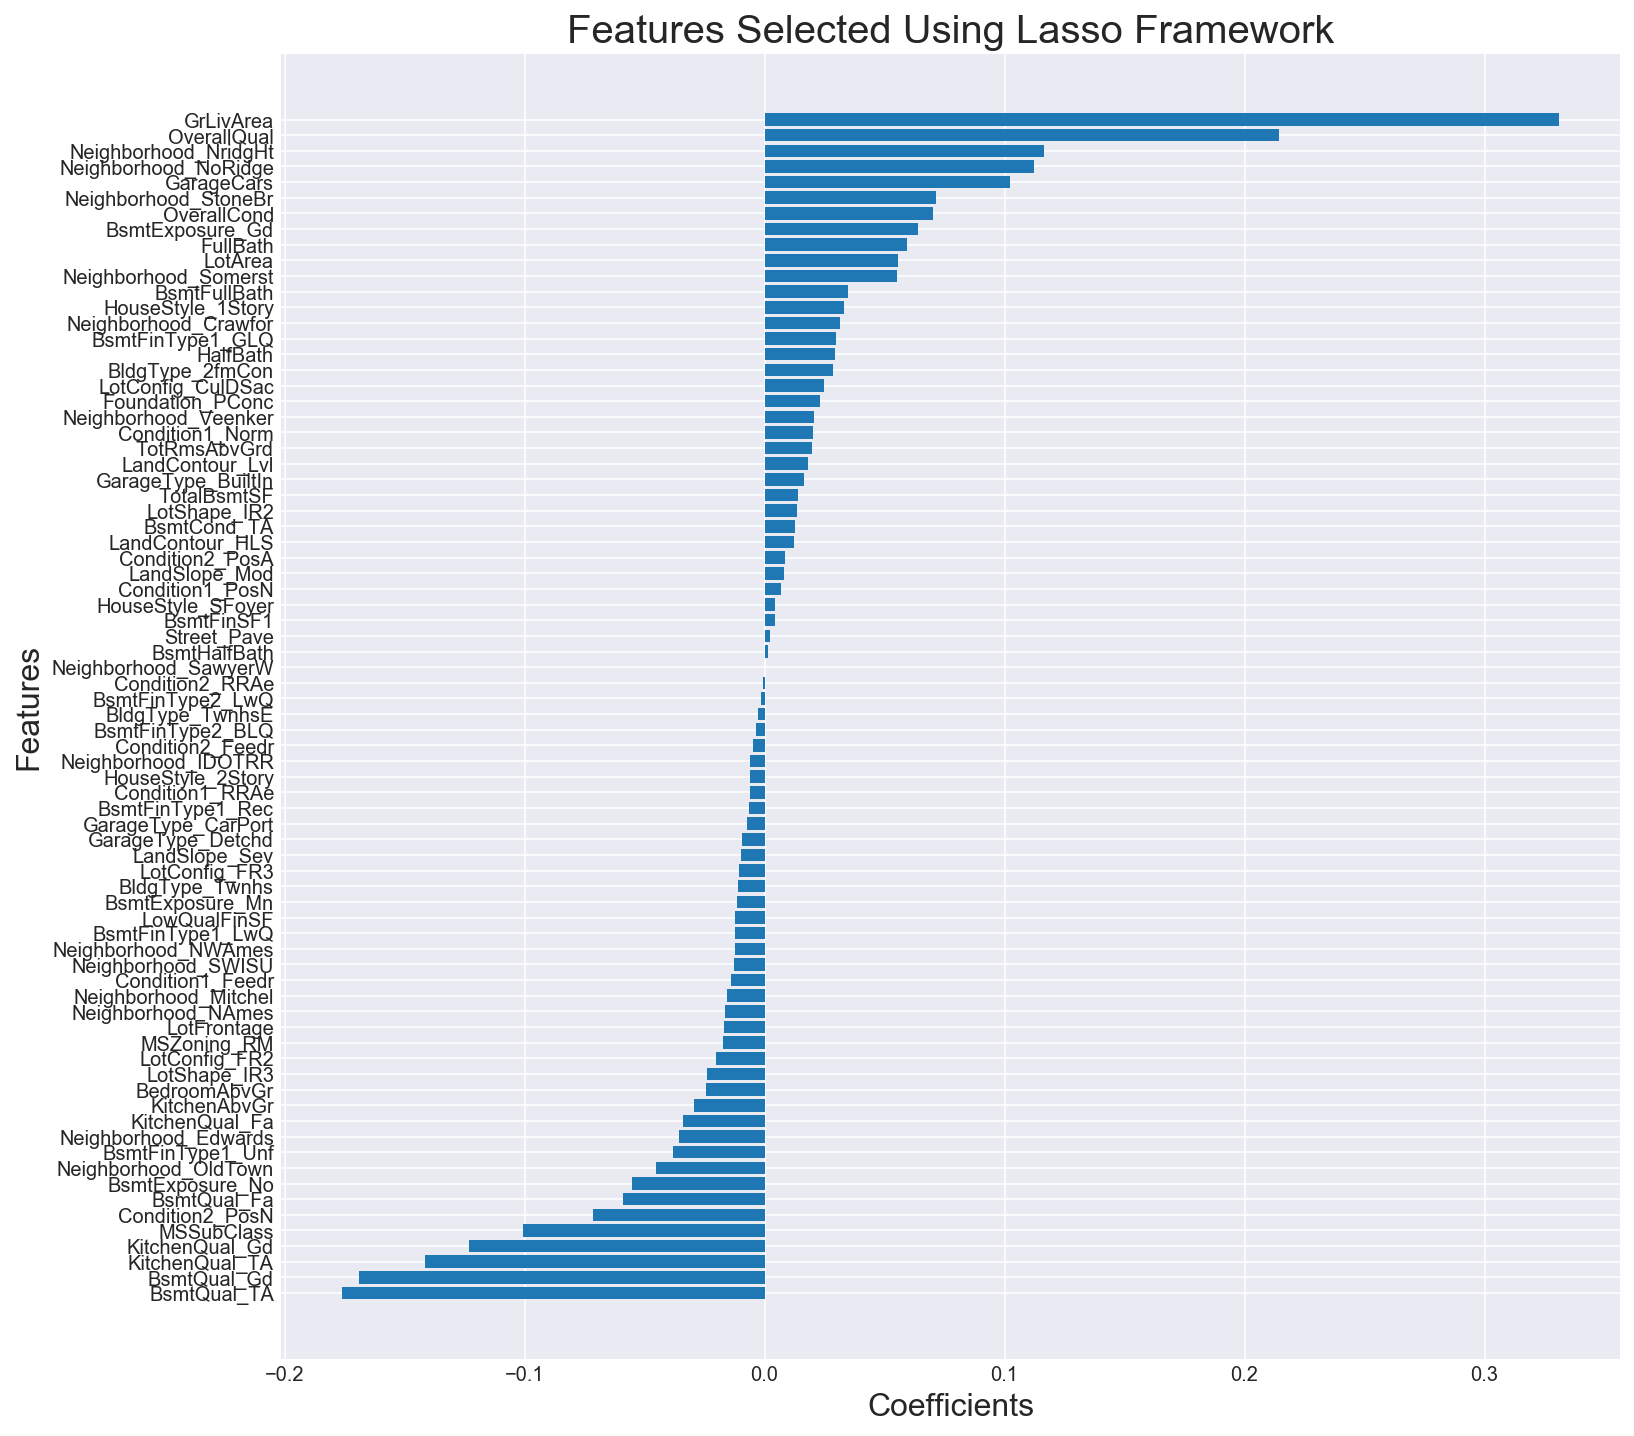

In [38]:
# create dataframe containing selected features and its coefficients sorted in ascending order
lasso_coefs_sorted = lasso_coefs[lasso_coefs['coef'] != 0].sort_values('coef',ascending=True)

# horizontal bar plot for selected features under Lasso framework
fig, ax = plt.subplots(figsize=(12,12))

ax.barh(lasso_coefs_sorted['variable'],lasso_coefs_sorted['coef'])

ax.set_title('Features Selected Using Lasso Framework',fontsize=20)
ax.set_xlabel('Coefficients',fontsize=16)
ax.set_ylabel('Features',fontsize=16)

plt.show()

### <font color='red'> Conclusion (question 1):
- The final model chosen is the one fitted under Lasso framework with score of 0.8092.
- The best estimates of price under Lasso framework is given by lasso_variables (shown above) <br>


- Further analysis can be taken by extracting the selected features from Lasso and fit them with sm.OLS and drop those features with p-values < 0.05
- Subsequently, run 5-folds cv to determine its mean score and see how it compares with the r^2 score on y_test_sc (test set) to see if model is over-fitted
- If the trained sm.OLS model is not over-fitted, we compare its score with that produced under Lasso framework

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### <font color='red'> Conclusion (question 2):

#### Evaluating the effect in dollars of the renovate-able features:

Qualitatively, we should obtain the residuals from our fixed features model as our target for renovate-able (non-fixed) features to predict.

We designate model 1 as trained with fixed features (with target: 'SalePrice') and model 2 as trained with non-fixed features (with target: residuals_from_fixed).

After training model 2, we compute its r^2 score to determine how much variation in residuals_from_fixed can be explained by renovate-able features. Assuming the r^2 score was > 0.80 (0.80 as the benchmark was chosen because Lasso modelling with fixed features had already returned 0.8092) and most of the renovate-able features are statistically significant (i.e. p-values < 0.05), then we can reliably trust the information the predicted residuals are telling us.

For example, if on average, (mean of predicted residuals - mean of residuals from fixed model) is positive, then we can infer that by adding renovate-able features, 'SalePrice' of our houses will increase.

Although this method is imperfect, the 'SalePrice' target can still be explained by fixed features, impact from renova-teable features and random errors resulted from modelling fixed and non-fixed features.

#### How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 

The company should use the second model in conjunction with the first model. This is because we are increasing the variation in our 'SalePrice' target that can be explained by fixed and non-fixed features, which implies that our predictions, on average, will be accurate on unseen data.

The utilization of coefficients can be used to determine whether the company should buy a property or not. For example, if we increase non-fixed feature by 1 point and its coefficient is 0.20, then in order to profit from flipping houses, the company should not spend more than 0.2% of the buying price on renovation to increase the non-fixed feature by 1 point .

#### Investigate how much of the variance in price remaining is explained by these features.
r^2 (from model 2) - r^2 (from model 1) gives the amount of variance in 'SalePrice' that is explained by renovate-able features and random errors resulted from model 1 and model 2 itself.

#### Do you trust your model? Should it be used to evaluate which properties to buy and fix up?
Assuming the residuals from model 2 are normally distributed, then one can trust the model for making predictions on SalePrice to evaluate which properties to buy and fix it up in order to make a profit.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: